In [87]:
import os
import platform
import sys

print("OS Name:", os.name)
print("Platfrom:", platform.system())
print("Platform Version:", platform.release())
print("Python Version:", platform.python_version())

OS Name: posix
Platfrom: Linux
Platform Version: 4.19.112+
Python Version: 3.7.10


In [88]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)     # random seed - choose whichever you want

# Turn off progress printing 
solvers.options['show_progress'] = False

In [89]:
import plotly
import cufflinks

In [91]:
# Number Of Assets!
n_assets = 4

# Number of Observations (return series of length 1000, e.g. 1000일동안 각 날짜의 return value)
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)     # randn = mean 0, sd 1  standard normal distribution random numbers

In [92]:
return_vec

# Shape: (4,1000)
# Size: 4000
# row 1 = asset 1's return series of length 1000

array([[-0.47127552,  1.08407243, -0.37922328, ..., -1.85971515,
         0.91382219, -1.35383977],
       [ 0.3187635 ,  1.51110387, -1.13662678, ...,  1.32491703,
        -0.45076279,  0.24077279],
       [ 0.22690673, -2.39855358, -0.44785801, ...,  0.87511309,
         0.45349999, -1.56310501],
       [ 1.11784894, -0.00572655,  1.51839373, ..., -1.60703467,
        -0.39076092,  1.14432029]])

Text(0, 0.5, 'returns')

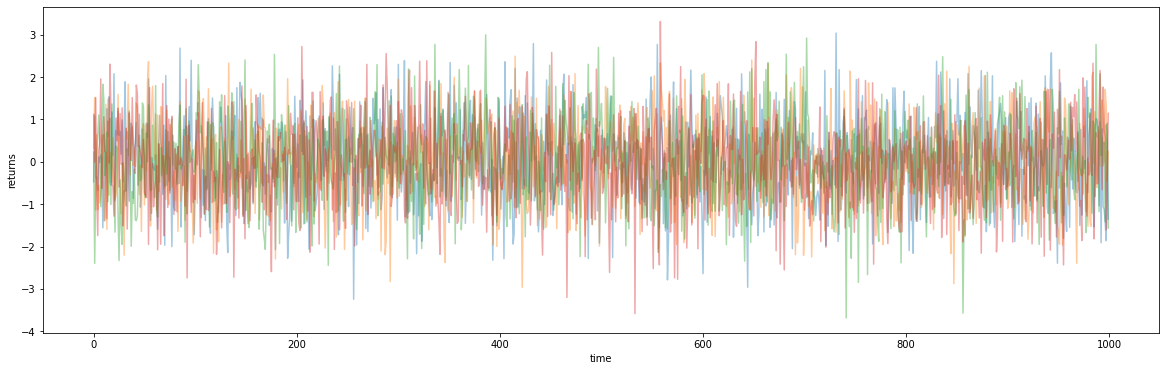

In [93]:
fig = plt.figure(figsize=(20,6))
plt.plot(return_vec.T, alpha = .4)
plt.xlabel('time')
plt.ylabel('returns')


Now create a function that generates random weights W=[W1, W2, W3, ... WN]

Note that sum of all weights must be 1

In [94]:
def rand_weights(n):
  k = np.random.rand(n)       # 0~1 사이에 uniform distribution 의 random number generation
  return k/sum(k)

In [96]:
print(rand_weights(10))
print(rand_weights(n_assets))

[0.06458009 0.0877662  0.11455239 0.07964117 0.05298503 0.0860251
 0.07883182 0.15589218 0.13119005 0.14853597]
[0.34457844 0.33533243 0.31372892 0.00636021]


By creating this list of weights, we have created a portfolio! (yay!)

We do not know whether it is an optimal portfolio yet.

However, we can still calculate the return (r_p) and variance (Var(r_p)) of the portfolio.

공식은 노션 참조

In [98]:
def random_portfolio(returns):
  # what is returns? = the matrix of we created above! (1st row = return series of length 1000 of asset 1, ...)
  p = np.asmatrix(np.mean(returns, axis=1)) # calculates the expected(mean) return of each asset
                                            # axis = 1 is to calculate mean horizontally (mean of 1000 return vals)
                                            # axis = 0 이면, 각 interval에서 4개 asset의 mean
  w = np.asmatrix(rand_weights(returns.shape[0])) # returns.shape[0] = number of assets
  C = np.asmatrix(np.cov(returns)) # cov(returns) = Covariance matrix Omega

  """
    now, p(1X4) w(1X4) C(4X4)
  """
  mu = w * p.T  # mu = r_p in notion    (1X4) X (4X1) = 1X1

  sigma = np.sqrt(w * C * w.T)    # sigma = sqrt(Var(r_p))  LN 에서는 w.T 를 (1 X N) 으로 DEFINE 함
  
  if sigma > 3:
    return random_portfolio(returns) # 그림그리기 편하게, sigma가 3보다 큰경우는 배제
  
  return mu, sigma



In [99]:
n_portfolios = 1000    


means, stds = np.column_stack([random_portfolio(return_vec) for _ in range(n_portfolios)])
# in python3, xrange = range 
# return_vec = information about assets (number of assets, return of each asset in each time interval)
# random_portfolio 함수 안에서 w = np.asmatrix(rand_weights(returns,shape[0])) line의 rand_weights() function call 을 통해 랜덤한 포트폴리오 (weight list) 생성
# 그리고 각 생성된 포트폴리오의 expected return, sd 반환
# 반환한 expected return, sd pair 갖고 list 에 append (n_portfolios=1000 만큼 iteration)




In [103]:
print(means.shape)
print(stds.shape)

(1000, 1)
(1000, 1)


In [104]:
for i in range(10):
  print('means: ', means[i], ' stds: ', stds[i])

means:  [0.0004441]  stds:  [0.57484133]
means:  [-0.0110796]  stds:  [0.58823431]
means:  [0.03218356]  stds:  [0.59888707]
means:  [0.01951028]  stds:  [0.54877625]
means:  [0.01077194]  stds:  [0.51915]
means:  [0.01620969]  stds:  [0.52975462]
means:  [-0.00109015]  stds:  [0.56482475]
means:  [-0.00605126]  stds:  [0.57758002]
means:  [0.01517061]  stds:  [0.55260891]
means:  [-0.00716735]  stds:  [0.59013681]


Text(0.5, 1.0, 'Mean and standard deviation of returns of randomly generated portfolios')

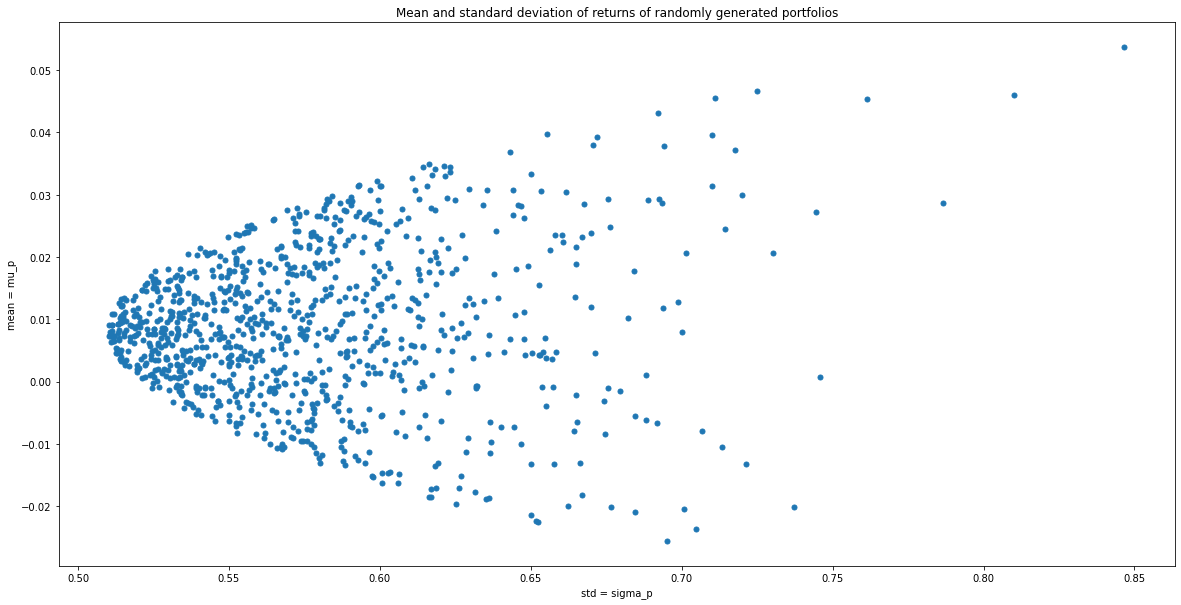

In [105]:
fig = plt.figure(figsize=(20, 10))
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std = sigma_p')
plt.ylabel('mean = mu_p')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

그래프 해석<br>
Y-axis = mean return of portfolio<br>
X-axis = standard deviation of portfolio (risk)<br>
Each instance = single portfolio (with random weights)<br>
Goal is to minimize risk, maximize return<br>
Gien a target return (horizontal line), choose the leftmost instance (minimum risk)<br>
Given a target risk (vertical line), choose the uppermost instance (maximum return)<br>

Find the optimal portfolio

In [110]:
def optimal_portfolio(returns):
  n = len(returns)
  returns = np.asmatrix(returns)

  N = 100     # number of target returns
  mus = [10 ** (5.0 * t/N - 1.0) for t in range(N)]      # list of target returns
                          ## 10^(0.05~5.00 - 1) = 10^(-0.95, -0.9, .... 4.00)
  

  # convert normal matrices into cvxopt matrices (so we can use them in cvxopt functions)
  S = opt.matrix(np.cov(returns))   # opt = cvxopt (for convex optimization) #  nXn matrix
  pbar = opt.matrix(np.mean(returns, axis = 1))  # np.mean(returns, axis=1) = mean return of each assets (4) # n x 1 MATRIX


  # create constraint matrices
  G = -opt.matrix(np.eye(n))   # negative n X n identity matrix 
  h = opt.matrix(0.0, (n,1))   # n x 1 matrix of all 0
  A = opt.matrix(1.0, (1,n))   # 1 x n matrix of all 1
  b = opt.matrix(1.0)          # 1 x 1 matrix of all 1

  # calculate efficient frontier weights using quadratic programming
  portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
  # solvers.qp(P, q, G, h, A, b) = solves x that minimizes x.T * P * x + q.T * x
                                # = solves x that minimizes x.T * (mu * S) * x  + -pbar.T * x     # x = weights, S = covaraince, mu = target return
                                 # subject to Gx <= h, Ax=b
                                 # Ax = b (sum of weights = 1)
                                 # Gx <= h (weights are positive = no short selling)
  
  # calculate risks and returns of the frontier portfolios
  returns = [blas.dot(pbar, x) for x in portfolios]   # pbar = mean return of each assets : pbar DOT x = sum of (w_i * r_i) = r_p (mean return of portfolio)
  risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]  # S = covaraince matrix  : x DOT S*x = var(portfolio) = weight * Covariance matrix (Omega) * weight.T

  # calculate the optimal portfolio (global minimum in the frontier curve)
  # 1. calculate the second degree polynomial of the frontier curve
  m1 = np.polyfit(returns, risks, 2)
  x1 = np.sqrt(m1[2] / m1[0])
  wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

  return wt, returns, risks

                      

solv

In [107]:
weights, returns, risks = optimal_portfolio(return_vec)

In [108]:
print(weights)

[ 7.37e-01]
[ 6.85e-07]
[ 2.63e-01]
[ 2.67e-07]



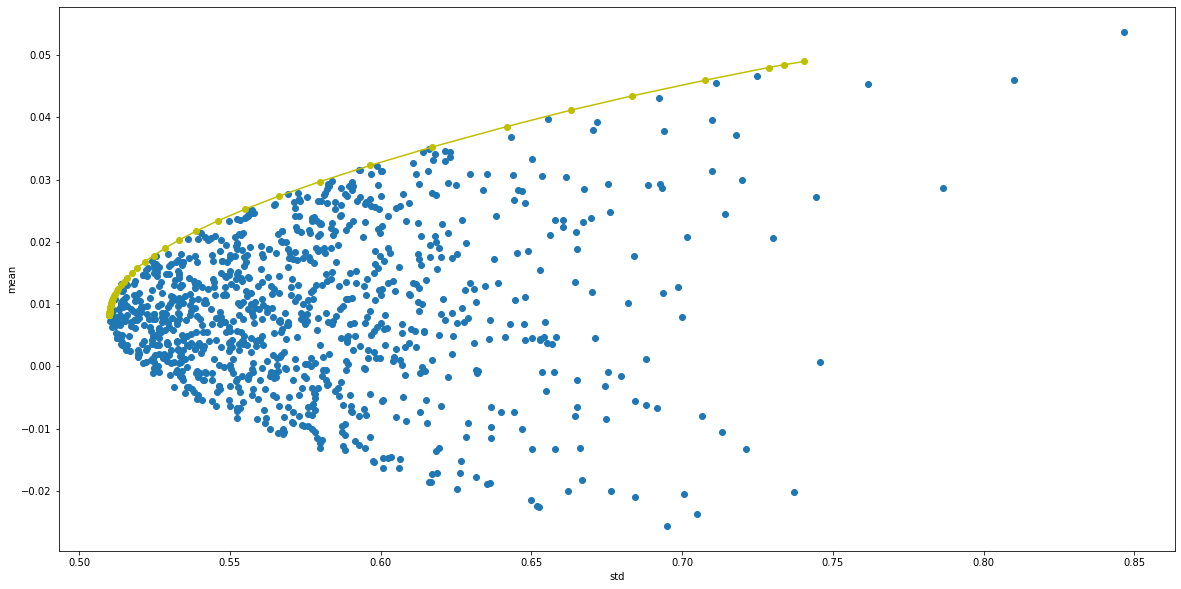

In [109]:
fig=plt.figure(figsize=(20, 10))
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')



In [111]:
!pip install finance-datareader

In [112]:
import FinanceDataReader as fdr

In [114]:
stocks_list = ['JNJ', 'WMT', 'JPM', 'AAPL', 'DIS', 'XOM']

# JNJ - JONHNSON & JOHNSON
# WMT - WALMART
# JPM - JPMORGAN
# AAPL - APPLE
# DIS - DISNEY
# XOM - EXXON MOBIL

def close_price_vector(stocks_list, start_date, end_date):
  
    df = fdr.DataReader(stocks_list[0], start_date, end_date)

    close_df = df.drop(['Open','High','Low','Volume','Change'], axis = 1)
    close_df.rename(columns = {'Close': stocks_list[0]}, inplace = True)

    change_df = df.drop(['Open', 'High', 'Low', 'Volume', 'Close'], axis = 1)
    change_df.rename(columns = {'Change': stocks_list[0]}, inplace = True)


    for i in range(1, len(stocks_list)):
      df = fdr.DataReader(stocks_list[i], start_date, end_date)
      close_df[stocks_list[i]] = df['Close']
      change_df[stocks_list[i]] = df['Change']
    
    return close_df, change_df



In [115]:
close_df, change_df = close_price_vector(stocks_list, '2018-01-01', '2021-03-31')

In [116]:
close_df

,JNJ,WMT,JPM,AAPL,DIS,XOM
Date,,,,,,
2018-01-02,139.23,98.59,107.95,43.06,111.80,85.03
2018-01-03,140.56,99.45,108.06,43.06,112.28,86.70
2018-01-04,140.55,99.54,109.04,43.26,112.23,86.82
2018-01-05,141.71,100.13,108.34,43.75,111.62,86.75
2018-01-08,141.89,101.61,108.50,43.59,110.02,87.14
...,...,...,...,...,...,...
2021-03-25,161.97,134.01,152.55,120.59,186.91,56.18
2021-03-26,164.93,135.13,155.09,121.21,185.92,57.71
2021-03-29,166.04,136.67,152.68,121.39,184.85,57.40


In [117]:
change_df

,JNJ,WMT,JPM,AAPL,DIS,XOM
Date,,,,,,
2018-01-02,-0.0035,-0.0016,0.0094,0.0177,0.0399,0.0166
2018-01-03,0.0096,0.0087,0.0010,0.0000,0.0043,0.0196
2018-01-04,-0.0001,0.0009,0.0091,0.0046,-0.0004,0.0014
2018-01-05,0.0083,0.0059,-0.0064,0.0113,-0.0054,-0.0008
2018-01-08,0.0013,0.0148,0.0015,-0.0037,-0.0143,0.0045
...,...,...,...,...,...,...
2021-03-25,0.0004,0.0068,0.0128,0.0042,0.0119,-0.0028
2021-03-26,0.0183,0.0084,0.0167,0.0051,-0.0053,0.0272
2021-03-29,0.0067,0.0114,-0.0155,0.0015,-0.0058,-0.0054


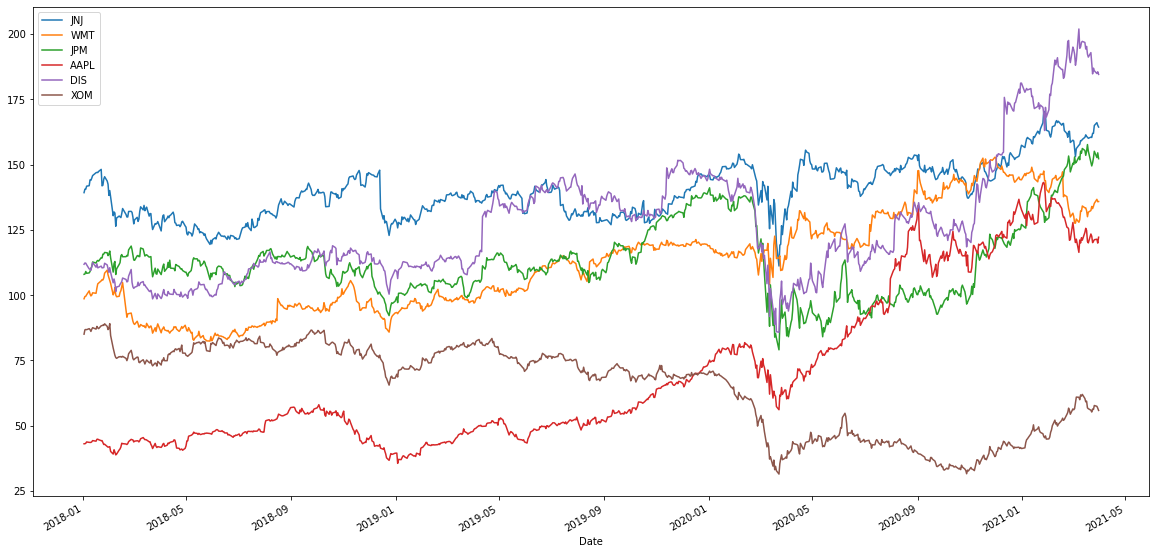

In [118]:
close_df.plot(figsize = (20, 10))

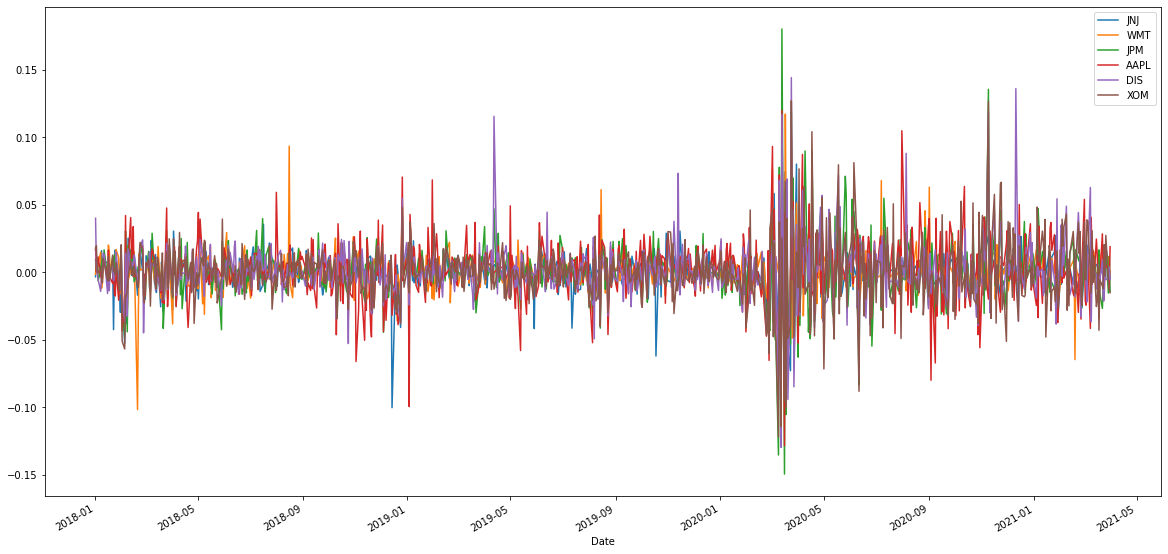

In [119]:
change_df.plot(figsize = (20,10))

In [120]:
change_vec = change_df.fillna(0).to_numpy().T*100
close_vec = close_df.to_numpy().T

In [123]:
change_vec

array([[-0.35,  0.96, -0.01, ...,  0.67, -0.62, -0.4 ],
       [-0.16,  0.87,  0.09, ...,  1.14, -0.68,  0.07],
       [ 0.94,  0.1 ,  0.91, ..., -1.55,  1.18, -1.46],
       [ 1.77,  0.  ,  0.46, ...,  0.15, -1.23,  1.88],
       [ 3.99,  0.43, -0.04, ..., -0.58,  0.37, -0.54],
       [ 1.66,  1.96,  0.14, ..., -0.54, -1.24, -1.52]])

In [35]:
first_half = change_vec[:, :400]
second_half = change_vec[:, 400:]

In [124]:
portfolio_num = 10000

custom_means, custom_sigmas = np.column_stack([random_portfolio(first_half) for _ in range(portfolio_num)])

Text(0.5, 0, 'std')

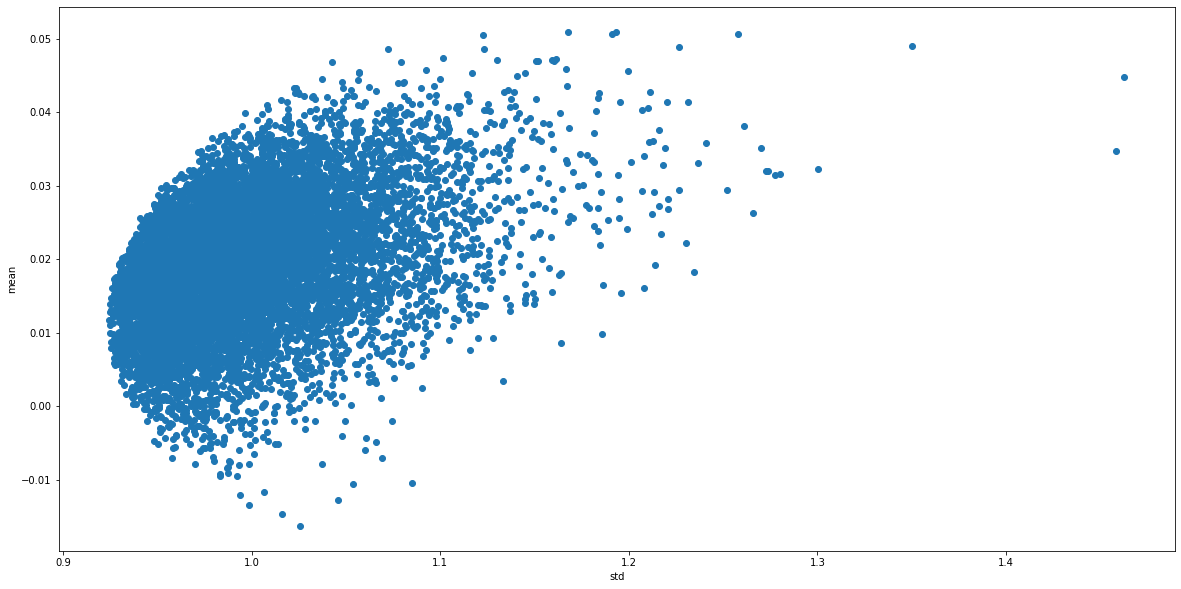

In [125]:
fig=plt.figure(figsize=(20, 10))
plt.plot(custom_sigmas, custom_means, 'o')
plt.ylabel('mean')
plt.xlabel('std')


In [126]:
custom_weight, custom_return, custom_risk = optimal_portfolio(first_half)

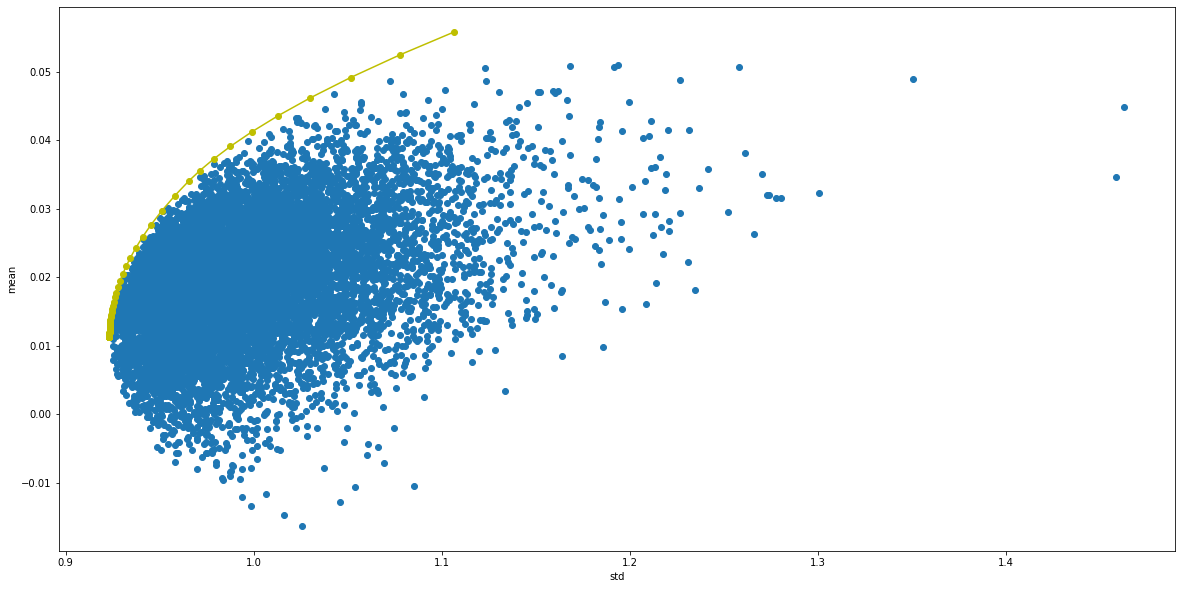

In [127]:
fig=plt.figure(figsize=(20, 10))
plt.plot(custom_sigmas, custom_means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(custom_risk, custom_return, 'y-o')

In [128]:
print(custom_weight)
# JNJ, WMT, JPM, AAPL, DIS, XOM
np.asmatrix(custom_weight).shape

[ 5.47e-07]
[ 2.93e-01]
[ 1.12e-05]
[ 1.08e-01]
[ 5.99e-01]
[ 2.17e-09]



(6, 1)

In [129]:
custom_mu = np.asmatrix(np.mean(first_half, axis = 1)) * np.asmatrix(custom_weight)

custom_sigma = np.sqrt(np.asmatrix(custom_weight).T * np.asmatrix(np.cov(first_half)) * np.asmatrix(custom_weight))

print('Return using our weight', custom_mu)
print('Risk using our weight', custom_sigma)

Return using our weight [[0.0560449]]
Risk using our weight [[1.10830339]]


In [130]:
initial_asset = 1000000

stocks_bought = []
for i in range(len(custom_weight)):
  stocks_bought.append(initial_asset * custom_weight[i] / close_vec[i, 400])

stocks_bought


[0.004184402419801488,
 2730.515739880744,
 0.10139182072101743,
 2202.5178900830347,
 4219.439095162667,
 3.061737517209592e-05]

In [131]:
current_asset = 0
balance = []
for i in range(second_half[0].size):
  current_asset = 0
  for j in range(len(stocks_bought)):
    current_asset += close_vec[j, 400+i] * stocks_bought[j]
  balance.append(current_asset)


In [132]:
balance

[1000000.0000000001,
 974084.1500072222,
 990165.7769370822,
 988094.6374288477,
 970495.3920208999,
 986461.2272496327,
 962190.0602103407,
 981723.4054990509,
 992716.6114613015,
 997449.9031704423,
 991968.9383751904,
 995800.7390604601,
 996762.6135763059,
 969787.4475235783,
 987474.5003830761,
 986864.7221898927,
 997124.8810038263,
 1008197.8929572285,
 1006110.025436232,
 1001443.0852847736,
 1013515.9031358163,
 1018487.8484642858,
 1019522.9816736507,
 1021360.6674516402,
 1009156.7744091123,
 1014573.0297446528,
 1022271.7017066816,
 1023479.8904559884,
 1009650.5677532379,
 1014809.6107709276,
 1019797.4042033314,
 1003901.6687335158,
 997416.5976965978,
 1000516.4490210138,
 1000005.9135073997,
 1006773.0020191274,
 997990.5976857058,
 992300.1241104737,
 997266.3638996533,
 992103.2561178546,
 982543.718788177,
 979920.3446435988,
 997309.1439427605,
 997450.0086442818,
 986698.526231571,
 995467.1730966021,
 999040.1913415081,
 1006999.6924213289,
 1002551.6475231,
 1003

In [133]:
df = close_df.iloc[400:]
df['Balance'] = balance
df['Balance'] = df['Balance']/10000
df

,JNJ,WMT,JPM,AAPL,DIS,XOM,Balance
Date,,,,,,,
2019-08-06,130.77,107.27,110.43,49.25,141.87,70.96,100.000000
2019-08-07,130.21,108.20,108.03,49.76,134.86,70.50,97.408415
2019-08-08,131.68,108.52,109.86,50.86,137.89,72.38,99.016578
2019-08-09,132.04,107.28,109.74,50.25,138.52,70.84,98.809464
2019-08-12,131.93,105.22,107.68,50.12,135.75,69.63,97.049539
...,...,...,...,...,...,...,...
2021-03-25,161.97,134.01,152.55,120.59,186.91,56.18,142.018955
2021-03-26,164.93,135.13,155.09,121.21,185.92,57.71,142.043632
2021-03-29,166.04,136.67,152.68,121.39,184.85,57.40,142.052273


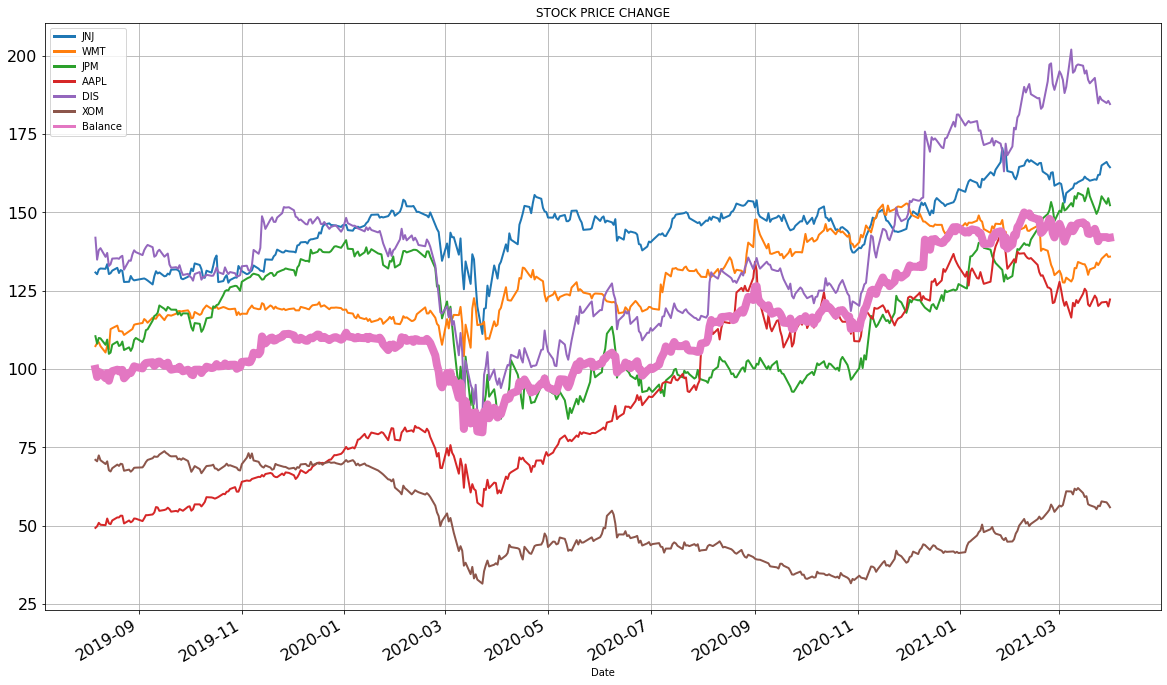

In [134]:

fig, ax = plt.subplots()
df.plot(figsize=(20,12), title='STOCK PRICE CHANGE', 
        lw=3, fontsize=16, ax=ax, grid=True)

for line in ax.get_lines():
    if line.get_label() == 'Balance':
        line.set_linewidth(8)
    else:
        line.set_linewidth(2)
plt.show()

In [135]:

dff = fdr.DataReader('US500', '2019-08-06', '2021-03-31')
dff = dff.drop(['Change', 'Open', 'High', 'Low', 'Volume'], axis = 1)
dff = dff.rename(columns = {'Close': 'US500'})
dff['US500'][0]

2881.77

In [136]:
dff['Balance'] = balance

dff['US500'] = dff['US500'] / dff['US500'][0] * 100
dff['Balance'] = dff['Balance'] / dff['Balance'][0] * 100
dff


,US500,Balance
Date,,
2019-08-06,100.000000,100.000000
2019-08-07,100.076689,97.408415
2019-08-08,101.954354,99.016578
2019-08-09,101.279769,98.809464
2019-08-12,100.068708,97.049539
...,...,...
2021-03-25,135.663845,142.018955
2021-03-26,137.920098,142.043632
2021-03-29,137.800380,142.052273


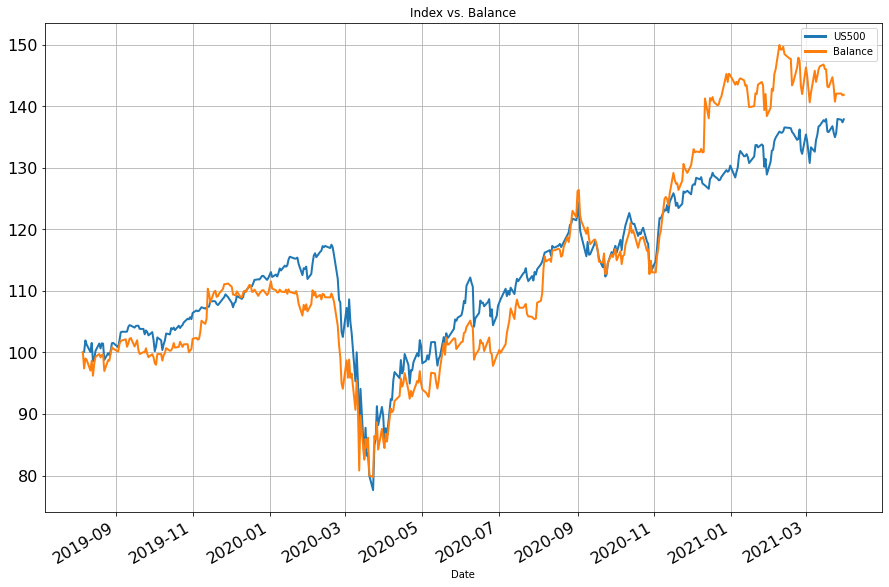

In [137]:

fig, ax = plt.subplots()
dff.plot(figsize=(15,10), title='Index vs. Balance', 
        lw=3, fontsize=16, ax=ax, grid=True)

for line in ax.get_lines():
    if line.get_label() == 'Balance':
        line.set_linewidth(2)
    else:
        line.set_linewidth(2)
plt.show()